# Introduction

Recently, I was reviewing Andrew Ng's team's work(https://stanfordmlgroup.github.io/projects/ecg/) on heart arrhythmia detector with convolutional neural networks (CNN). I found this quite fascinating especially with emergence of wearable products (e.g. Apple Watch and portable EKG machines) that are capable of monitoring your heart while at home. As such, I was curious how to build a machine learning algorithm that could detect abnormal heart beats. Here we will use an ECG signal (continuous electrical measurement of the heart) and train 3 neural networks to predict heart arrythmias: dense neural network, CNN, and LSTM.  

We will use the MIH-BIH Arrythmia dataset from https://physionet.org/content/mitdb/1.0.0/. This is a dataset with 48 half-hour two-channel ECG recordings measured at 360 Hz. The recordings have annotations from cardiologists for each heart beat. The symbols for the annotations can be found at https://archive.physionet.org/physiobank/annotations.shtml

In [1]:
!pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d amritpal333/mitbih-with-atr-and-dat-files
!unzip -q /content/mitbih-with-atr-and-dat-files.zip

 62% 39.0M/63.1M [00:00<00:00, 67.5MB/s]
100% 63.1M/63.1M [00:00<00:00, 142MB/s] 


# Project Definition

Predict if a heart beat from the first ECG signal has an arrhythmia for each 6 second window centered on the peak of the heart beat. 

To simplify the problem, we will assume that a QRS detector is capable of automatically identifying the peak of each heart beat. We will ignore any non-beat annotations and any heart beats in the first or last 3 seconds of the recording due to reduced data. We will use a window of 6 seconds so we can compare the current beat to beats just before and after. This decision was based after talking to a physician who said it is easier to identify if you have something to compare it to. 

# Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir


In [9]:
# data must be downloaded and path provided
data_path = '/content/MIT-BIH- atr dat files-1/'


In [4]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

Here we will use a pypi package wfdb for loading the ecg and annotations.  

In [6]:
!pip install wfdb

     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 6.6MB 6.9MB/s 
     |████████████████████████████████| 163kB 30.8MB/s 


In [7]:
import wfdb

Let's load all the annotations and see the distribution of heart beat types across all files. 

In [10]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [11]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [12]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [13]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [14]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

Let's write a function for loading a single patient's signals and annotations. Note the annotation values are the indices of the signal array. 

In [15]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

Let's check out what abnormal beats are in a patient's ecg:

In [16]:
file = data_path + pts[0]

In [17]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [18]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


Let's make a plot of these, zooming in on one of the abnormal beats

In [19]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [20]:
x = np.arange(len(p_signal))

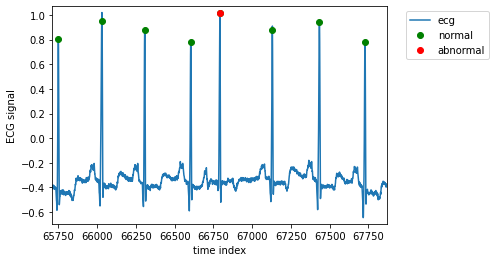

In [21]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

# Make a dataset

Let's make a dataset that is centered on beats with +- 3 seconds before and after. 

In [22]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym
    

# Lesson 1: split on patients not on samples

Let's start by processing all of our patients.

In [23]:
num_sec = 3
fs = 360

In [24]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

Imagine we naively just decided to randomly split our data by samples into a train and validation set. 

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

Now we are ready to build our first dense NN. We will do this in Keras for simplicity. 

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [27]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [28]:
# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [29]:
model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
73096/73096 [==============================] - 7s 95us/step - loss: 0.2516 - accuracy: 0.9062
Epoch 2/5
73096/73096 [==============================] - 7s 99us/step - loss: 0.1667 - accuracy: 0.9464
Epoch 3/5
73096/73096 [==============================] - 7s 100us/step - loss: 0.1453 - accuracy: 0.9539
Epoch 4/5
73096/73096 [==============================] - 7s 97us/step - loss: 0.1319 - accuracy: 0.9590
Epoch 5/5
73096/73096 [==============================] - 7s 98us/step - loss: 0.1254 - accuracy: 0.9612


In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [31]:
y_train_preds_dense = model.predict_proba(X_train,verbose = 1)
y_valid_preds_dense = model.predict_proba(X_valid,verbose = 1)

36003/36003 [==============================] - 1s 33us/step


In [32]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.3147641457808909

In [33]:
print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);

Train
AUC:0.992
accuracy:0.970
recall:0.948
precision:0.958
specificity:0.981
prevalence:0.315
 
Valid
AUC:0.988
accuracy:0.965
recall:0.940
precision:0.949
specificity:0.977
prevalence:0.314
 


Amazing! Not that hard! But wait, will this work on new patients? Perhaps not if each patient has a unique heart signature. Technically the same patient can show up in both the training and validation sets. This means that we may have accidentally leaked information across the datasets. 

We can try this again by splitting on patients instead of samples. 

In [34]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_valid))

36 12


In [35]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [36]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
80614/80614 [==============================] - 7s 91us/step - loss: 0.2312 - accuracy: 0.9172
Epoch 2/5
80614/80614 [==============================] - 7s 91us/step - loss: 0.1463 - accuracy: 0.9569
Epoch 3/5
80614/80614 [==============================] - 7s 90us/step - loss: 0.1258 - accuracy: 0.9626
Epoch 4/5
80614/80614 [==============================] - 7s 92us/step - loss: 0.1177 - accuracy: 0.9663
Epoch 5/5
80614/80614 [==============================] - 7s 93us/step - loss: 0.1106 - accuracy: 0.9679


In [37]:
y_train_preds_dense = model.predict_proba(X_train,verbose = 1)
y_valid_preds_dense = model.predict_proba(X_valid,verbose = 1)

28485/28485 [==============================] - 1s 28us/step


In [38]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [39]:
print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);

Train
AUC:0.994
accuracy:0.978
recall:0.960
precision:0.967
specificity:0.986
prevalence:0.299
 
Valid
AUC:0.837
accuracy:0.767
recall:0.457
precision:0.808
specificity:0.939
prevalence:0.358
 


Validation score is much different now! Makes sense since we had data leakage before. 

# Lesson 2: learning curve can tells us we should get more data! 

Given the overfitting between training and validation. Let's make a simple learning curve to see if we should go collect more data. 

In [40]:
aucs_train = []
aucs_valid = []

n_pts = [1,18,36]
for n_pt in n_pts:
    
    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)

    # build the same model
    # lets test out relu (a different activation function) and add drop out (for regularization)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(1, activation = 'sigmoid'))

    # compile the model - use categorical crossentropy, and the adam optimizer
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

    model.fit(X_sub, y_sub, batch_size = 32, epochs= 5, verbose = 0)
    y_sub_preds_dense = model.predict_proba(X_sub,verbose = 0)
    y_valid_preds_dense = model.predict_proba(X_valid,verbose = 0)
    
    auc_train = roc_auc_score(y_sub, y_sub_preds_dense)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
    print('-',auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)

1
- 0.949710347987361 0.6886200661727264
18
- 0.9947687254110122 0.7826627403145497
36
- 0.9925233097158886 0.8529050331011112


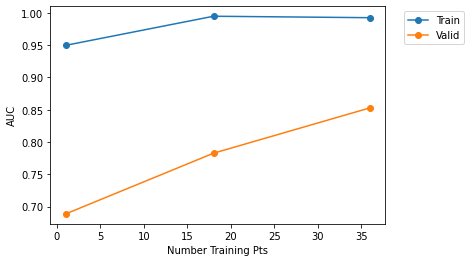

In [41]:
plt.plot(n_pts, aucs_train, 'o-',label = 'Train')
plt.plot(n_pts, aucs_valid, 'o-',label = 'Valid')
plt.xlabel('Number Training Pts')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

More data appears to add extra value to the model. 

# Lesson 3: test multiple types of deep learning models

## CNN - 1D

Let's start by making a CNN. Here we will use a 1 dimensional CNN (as opposed to the 2D CNN for images). 

A CNN is a special type of deep learning algorithm which uses a set of filters and the convolution operator to reduce the number of parameters. This algorithm sparked the state-of-the-art techniques for image classification. Essentially, the way this works for 1D CNN is to take a filter (kernel) of size `kernel_size` starting with the first time stamp. The convolution operator takes the filter and multiplies each element against the first `kernel_size` time steps. These products are then summed for the first cell in the next layer of the neural network. The filter then moves over by `stride` time steps and repeats. The default `stride` in Keras is 1, which we will use. In image classification, most people use `padding` which allows you pick up some features on the edges of the image by adding 'extra' cells, we will use the default padding which is 0. The output of the convolution is then multiplied by a set of weights W and added to a bias b and then passed through a non-linear activation function as in dense neural network. You can then repeat this with addition CNN layers if desired. Here we will use Dropout which is a technique for reducing overfitting by randomly removing some nodes. 

In [42]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)


(80614, 2160, 1)
(28485, 2160, 1)


In [43]:
from keras.layers import Conv1D

In [44]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [45]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
80614/80614 [==============================] - 383s 5ms/step - loss: 0.1998 - accuracy: 0.9333
Epoch 2/2
80614/80614 [==============================] - 380s 5ms/step - loss: 0.1187 - accuracy: 0.9653


In [46]:
y_train_preds_cnn = model.predict_proba(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict_proba(X_valid_cnn,verbose = 1)

28485/28485 [==============================] - 21s 740us/step


In [47]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.991
accuracy:0.974
recall:0.937
precision:0.974
specificity:0.989
prevalence:0.299
 
Valid
AUC:0.911
accuracy:0.837
recall:0.662
precision:0.850
specificity:0.935
prevalence:0.358
 


## LSTM

In [48]:
from keras.layers import Bidirectional, LSTM

In [49]:
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

Reduce dataset to make this feasible for weekend project

In [50]:
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs= 1, verbose = 1)

Epoch 1/1
10000/10000 [==============================] - 644s 64ms/step - loss: 0.5082 - accuracy: 0.7595


In [51]:
y_train_preds_lstm = model.predict_proba(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm = model.predict_proba(X_valid_cnn,verbose = 1)

28485/28485 [==============================] - 294s 10ms/step


In [52]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.799
accuracy:0.778
recall:0.946
precision:0.703
specificity:0.617
prevalence:0.489
 
Valid
AUC:0.496
accuracy:0.479
recall:0.542
precision:0.352
specificity:0.444
prevalence:0.358
 


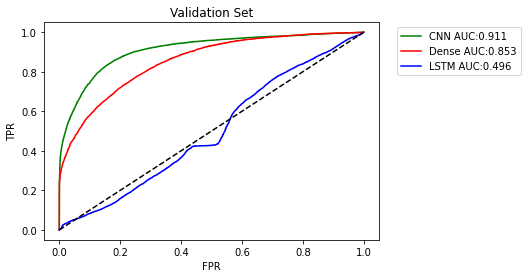

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()